In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 97% 548M/567M [00:07<00:00, 75.8MB/s]
100% 567M/567M [00:07<00:00, 77.2MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mpox-skin-lesion-dataset-version-20-msld-v20.zip','r')
zip_ref.extractall ('/content')
zip_ref.close()

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/HAM10000.zip','r')
dataset_dir= zip_ref.extractall ('/content')
zip_ref.close()

In [7]:
#Importing all the required libraries
!pip install innvestigate
import innvestigate
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import pandas as pd
#for Math operations
import numpy as np
#Machine learning libraries
import os
from random import shuffle
from shutil import copyfile
import random
#for opening and loading images
!pip install opencv-python
import cv2
# for Preprocessing
from tensorflow.keras.preprocessing import image
#for visualization
import plotly.express as px
import matplotlib.pyplot as plt
#convert class labels to one-hot encoded vectors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from keras.optimizers import Adam
from sklearn.utils import resample
from tensorflow.keras.utils import Sequence

from numpy import loadtxt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: ten

In [8]:
train_folder = "/content/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train"
val_folder = "/content/Original Images/Original Images/FOLDS/fold5/Valid"
test_folder = "/content/Original Images/Original Images/FOLDS/fold5/Test"

In [9]:
BATCH_SIZE = 16
train_gen = ImageDataGenerator(rescale=1./255)  # Normalization done to rescale the pixel values of the images to a range of [0, 1] by dividing by 255
train_data = train_gen.flow_from_directory(directory=train_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

val_gen = ImageDataGenerator(rescale=1./255)
val_data = val_gen.flow_from_directory(directory=val_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(directory=test_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed = 42)
train_data.class_indices

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

In [10]:
x,y = next(train_data)
x.shape

(16, 224, 224, 3)

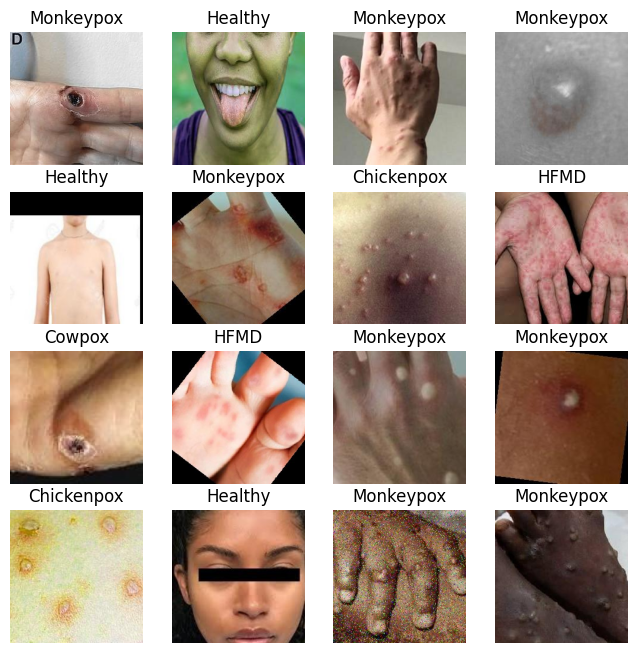

In [11]:
# OR we can display simply by
a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[8, 10])
    for i in range(len(img)):
        plt.subplot(5, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(x,y)

In [12]:
# def class_distrubution(folder):
#   # Calculate class distribution
#   class_names = os.listdir(folder)
#   class_dis = [len(os.listdir(folder + "/" + name)) for name in class_names]
#   fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
#   fig.update_layout(title_x = 0.47)
#   fig.show()



In [13]:
# class_distrubution(train_folder)
# #class_distrubution(val_folder)

Perform Upsampling

In [14]:
# Extract features and labels
X_train, y_train = [], []

for i in range(len(train_data)):
    X_batch, y_batch = train_data[i]
    X_train.extend(X_batch)
    y_train.extend(y_batch)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Get the class counts
class_counts = np.sum(y_train, axis=0)

# Find the class with the maximum count
max_class_count = int(np.max(class_counts))

# Upsample minority classes
X_upsampled, y_upsampled = [], []

for i in range(len(class_counts)):
    X_class = X_train[y_train[:, i] == 1]
    y_class = y_train[y_train[:, i] == 1]

    # Upsample the minority class
    X_class_upsampled, y_class_upsampled = resample(X_class, y_class, replace=True, n_samples=max_class_count, random_state=42)

    X_upsampled.extend(X_class_upsampled)
    y_upsampled.extend(y_class_upsampled)

X_upsampled = np.array(X_upsampled)
y_upsampled = np.array(y_upsampled)

# Shuffle the upsampled data
indices = np.arange(len(X_upsampled))
np.random.shuffle(indices)

X_upsampled = X_upsampled[indices]
y_upsampled = y_upsampled[indices]

# Convert one-hot encoded labels to class labels
y_upsampled_classes = np.argmax(y_upsampled, axis=1)

# Count the occurrences of each class
class_counts_upsampled = np.bincount(y_upsampled_classes)

# Print the counts
for class_index, count in enumerate(class_counts_upsampled):
    print(f"Class {class_index}: {count} images")


Class 0: 2968 images
Class 1: 2968 images
Class 2: 2968 images
Class 3: 2968 images
Class 4: 2968 images
Class 5: 2968 images


In [15]:
#Create a new ImageDataGenerator with augmentation

class AugmentedDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, datagen):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.datagen = datagen
        self.indexes = np.arange(len(self.X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indexes]
        y_batch = self.y[batch_indexes]

        augmented_X_batch = np.array([self.datagen.random_transform(img) for img in X_batch])

        return augmented_X_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Create an instance of the augmented data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_train_data = AugmentedDataGenerator(X_upsampled, y_upsampled, BATCH_SIZE, train_datagen)



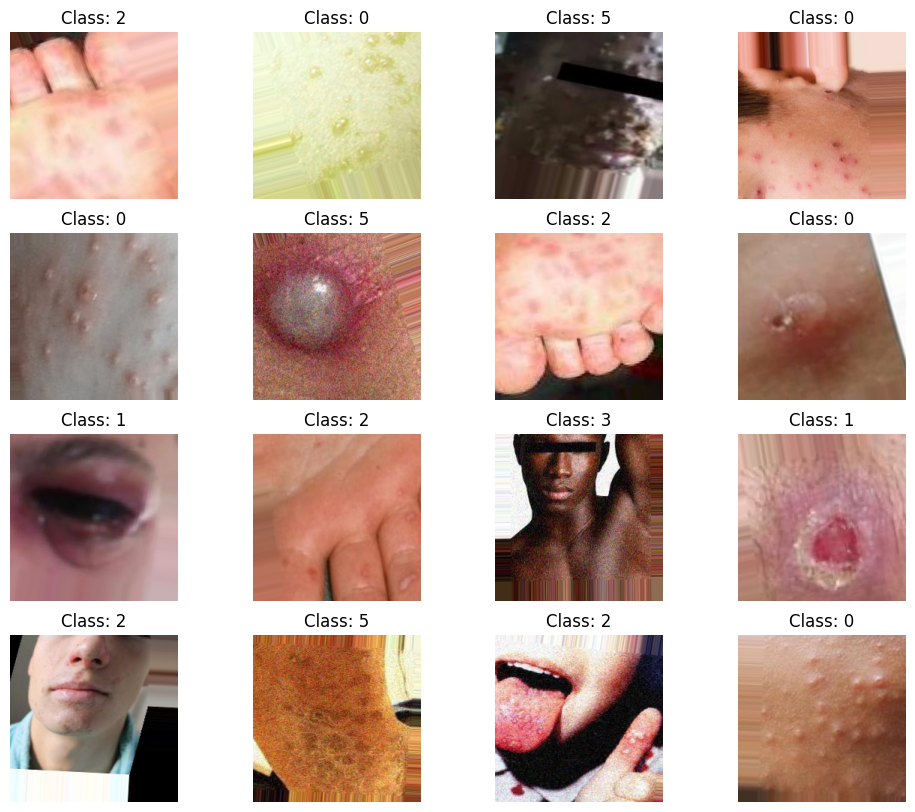

In [16]:
# Display images from AugmentedDataGenerator
def display_augmented_images(data_generator, num_images=16):
    X_batch, y_batch = data_generator.__getitem__(0)
    y_classes = np.argmax(y_batch, axis=1)

    plt.figure(figsize=(12, 10))
    for i in range(num_images):
        ax = plt.subplot(4, 4, i + 1)
        img = X_batch[i]
        plt.imshow(img)
        plt.title(f"Class: {y_classes[i]}")
        plt.axis("off")
    plt.show()

display_augmented_images(augmented_train_data)

In [17]:

# # Define paths to HAM10000 dataset
# dataset_dir = '/content/drive/MyDrive/Colab Notebooks/HAM1000'
# ham_part1 = os.path.join(dataset_dir, '/content/ham10000_images_part_1')
# ham_part2 = os.path.join(dataset_dir, '/content/ham10000_images_part_2')
# metadata_path = os.path.join(dataset_dir, '/content/HAM10000_metadata.csv')
# output_dir = '/content/drive/MyDrive/Colab Notebooks/HAM10000'

# # Load metadata
# metadata = pd.read_csv(metadata_path)

# class_mapping = {
#     'akiec': 'class1',
#     'bcc': 'class2',
#     'bkl': 'class3',
#     'df': 'class4',
#     'mel': 'class5',
#     'nv': 'class6',
#     'vasc': 'class7'
# }


In [18]:
# # Create directories
# for split in ['train', 'validation', 'test']:
#     for class_name in class_mapping.values():
#         os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# # Split metadata into training, validation, and test sets
# train_val_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
# train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['dx'], random_state=42)

# # Helper function to copy images to corresponding directories
# def copy_images(df, split):
#     for _, row in df.iterrows():
#         img_name = row['image_id'] + '.jpg'
#         if os.path.exists(os.path.join(ham_part1, img_name)):
#             src_path = os.path.join(ham_part1, img_name)
#         else:
#             src_path = os.path.join(ham_part2, img_name)
#         dst_dir = os.path.join(output_dir, split, class_mapping[row['dx']])
#         copyfile(src_path, os.path.join(dst_dir, img_name))

# # Copy images to respective directories
# copy_images(train_df, 'train')
# copy_images(val_df, 'validation')
# copy_images(test_df, 'test')

# print("Dataset organized successfully.")

In [19]:
# Define paths
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/HAM10000'

# Define ImageDataGenerators
ham_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ham_val_datagen = ImageDataGenerator(rescale=1./255)

ham_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
ham_train_generator = ham_train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

ham_val_generator = ham_val_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

ham_test_generator = ham_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6009 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


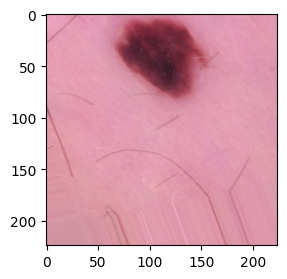

In [20]:
plt.figure(figsize=(3,3))
plt.imshow(ham_train_generator[0][0][0])

# Building the Model

## Model 1 : ResNet50

In [21]:
# # Create TensorFlow datasets from ImageDataGenerators(to be continused from above where we created train_data, val_data, test_data from flow_from_directory command)
# train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, train_data.num_classes]))
# val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, val_data.num_classes]))
# test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, test_data.num_classes]))

# # Apply prefetch and autotune
# train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
# Callbacks are used to perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).
# In our case, we are using Modelcheckpoint for saving the model weights into the disk for a minimum value of validation loss. Further,
# we are also using ReduceLROnPlateau for reducing the learning rate of the model by a factor of 0.5 if its validation loss doesn’t improve for 3 consecutive epochs.

checkpoint = ModelCheckpoint('.mdl1_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [23]:
# Load the ResNet50 model pretrained on ImageNet data and use fine tuning

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


Pre-train on HAM10000 dataset

In [24]:
# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

# Add custom layers for HAM10000
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes_ham, activation='softmax')(x)

model_ham = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

Epoch 1/10
188/188 [==============================] - 3299s 18s/step - loss: 1.1802 - accuracy: 0.6570 - val_loss: 1.1511 - val_accuracy: 0.6695
Epoch 2/10
188/188 [==============================] - 218s 1s/step - loss: 1.1402 - accuracy: 0.6695 - val_loss: 1.1264 - val_accuracy: 0.6695
Epoch 3/10
188/188 [==============================] - 218s 1s/step - loss: 1.1270 - accuracy: 0.6693 - val_loss: 1.1175 - val_accuracy: 0.6695
Epoch 4/10
188/188 [==============================] - 220s 1s/step - loss: 1.1205 - accuracy: 0.6693 - val_loss: 1.1104 - val_accuracy: 0.6695
Epoch 5/10
188/188 [==============================] - 220s 1s/step - loss: 1.1201 - accuracy: 0.6692 - val_loss: 1.1157 - val_accuracy: 0.6690
Epoch 6/10
188/188 [==============================] - 221s 1s/step - loss: 1.1162 - accuracy: 0.6695 - val_loss: 1.1104 - val_accuracy: 0.6695
Epoch 7/10
188/188 [==============================] - 221s 1s/step - loss: 1.1109 - accuracy: 0.6688 - val_loss: 1.0924 - val_accuracy: 0.67

Modify the Model for Monkeypox

In [25]:

# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

Fine-tune on Monkepypox dataset

In [26]:
# Unfreeze some top layers for fine-tuning
for layer in conv_base.layers[:]:
    layer.trainable = True

# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

history = model_mpox.fit(
    augmented_train_data,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=40,verbose=1, callbacks=callbacks
)

Epoch 1/40
1113/1113 [==============================] - ETA: 0s - loss: 1.5010 - accuracy: 0.4984
Epoch 1: val_accuracy improved from -inf to 0.48052, saving model to .mdl1_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1113/1113 [==============================] - 1208s 1s/step - loss: 1.5010 - accuracy: 0.4984 - val_loss: 1.5323 - val_accuracy: 0.4805 - lr: 1.0000e-04
Epoch 2/40
1113/1113 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.5485
Epoch 2: val_accuracy improved from 0.48052 to 0.70130, saving model to .mdl1_wts.hdf5
1113/1113 [==============================] - 1189s 1s/step - loss: 1.4067 - accuracy: 0.5485 - val_loss: 1.3747 - val_accuracy: 0.7013 - lr: 1.0000e-04
Epoch 3/40
1113/1113 [==============================] - ETA: 0s - loss: 1.3366 - accuracy: 0.5650
Epoch 3: val_accuracy did not improve from 0.70130
1113/1113 [==============================] - 1186s 1s/step - loss: 1.3366 - accuracy: 0.5650 - val_loss: 1.4425 - val_accuracy: 0.6234 - lr: 1.0000e-04
Epoch 4/40
1113/1113 [==============================] - ETA: 0s - loss: 1.2678 - accuracy: 0.5730
Epoch 4: val_accuracy did not improve from 0.70130
1113/1113 [==============================] - 1186s 1s/step - 

KeyboardInterrupt: 

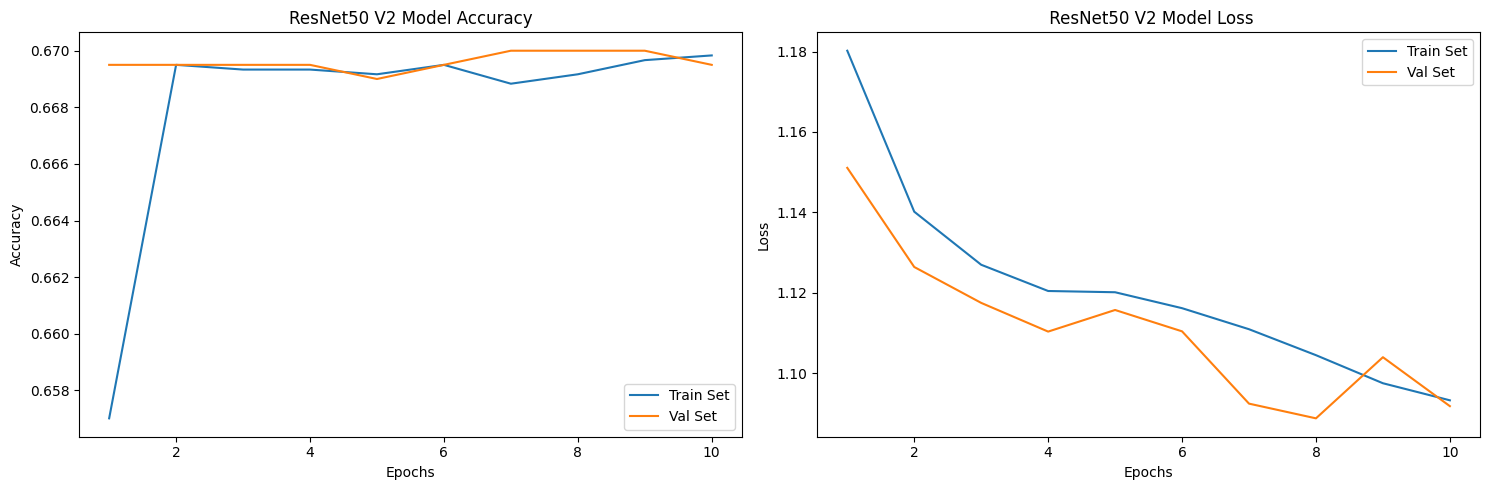

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' ResNet50 V2 Model Loss')

plt.tight_layout()
plt.show()

In [28]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl1_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 266ms/step - loss: 1.3747 - accuracy: 0.7013
[1.3747128248214722, 0.701298713684082]


model performed moderately well on test data with an overall validation accuracy of ---%. But now we will evaluate it on completely unseen test data so that we can assess its performance in a real sense

In [29]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 272ms/step - loss: 1.4113 - accuracy: 0.6032

 Test_Accuracy:- 0.60317462682724


Confusion Matrix

4/4 [==============================] - 2s 336ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       1.00      0.43      0.60         7
           2       0.59      0.87      0.70        15
           3       0.62      0.80      0.70        10
           4       0.00      0.00      0.00         6
           5       0.56      0.78      0.65        18

    accuracy                           0.60        63
   macro avg       0.46      0.48      0.44        63
weighted avg       0.51      0.60      0.53        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


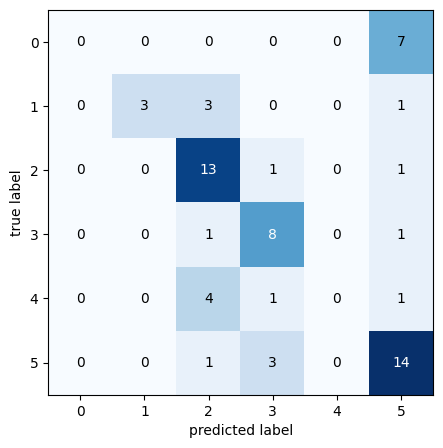

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("ResNet50-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

ResNet50-based Model Accuracy: 60.32%
Precision: 0.461
Recall: 0.479
F1 Score: 0.442


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2: MobileNet V2



In [32]:
checkpoint = ModelCheckpoint('.mdl2_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [33]:
conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(num_classes_ham, activation='softmax')(x)
model_ham = Model(conv_base.input, predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
188/188 [==============================] - 150s 783ms/step - loss: 2.8165 - accuracy: 0.1749 - val_loss: 1.8876 - val_accuracy: 0.2506
Epoch 2/10
188/188 [==============================] - 145s 774ms/step - loss: 2.4313 - accuracy: 0.2237 - val_loss: 1.6216 - val_accuracy: 0.4448
Epoch 3/10
188/188 [==============================] - 145s 774ms/step - loss: 2.1717 - accuracy: 0.2966 - val_loss: 1.4059 - val_accuracy: 0.5582
Epoch 4/10
188/188 [==============================] - 146s 778ms/step - loss: 1.9599 - accuracy: 0.3551 - val_loss: 1.3412 - val_accuracy: 0.5886
Epoch 5/10
188/188 [==============================] - 146s 776ms/step - loss: 1.8121 - accuracy: 0.4087 - val_loss: 1.2321 - val_accuracy: 0.6246
Epoch 6/10
188/188 [==============================] - 146s 778ms/step - loss: 1.7030 - accuracy: 0.4525 - val_loss: 1.1223 - val_accuracy: 0.6565
Epoch 7/10
188/188 [==============================] - 145s 77

In [34]:
# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

In [35]:
# Unfreeze some layers in the base model

for layer in conv_base.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False
for layer in conv_base.layers[100:]:  # Unfreeze the rest
    layer.trainable = True
# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics = ["accuracy"])


history = model_mpox.fit(
    augmented_train_data,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=30,verbose=1, callbacks=callbacks
)

Epoch 1/30
1113/1113 [==============================] - ETA: 0s - loss: 1.7489 - accuracy: 0.2311
Epoch 1: val_accuracy improved from -inf to 0.12338, saving model to .mdl2_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1113/1113 [==============================] - 272s 238ms/step - loss: 1.7489 - accuracy: 0.2311 - val_loss: 1.7226 - val_accuracy: 0.1234 - lr: 1.0000e-05
Epoch 2/30
1113/1113 [==============================] - ETA: 0s - loss: 1.6892 - accuracy: 0.2758
Epoch 2: val_accuracy improved from 0.12338 to 0.16883, saving model to .mdl2_wts.hdf5
1113/1113 [==============================] - 266s 239ms/step - loss: 1.6892 - accuracy: 0.2758 - val_loss: 1.6427 - val_accuracy: 0.1688 - lr: 1.0000e-05
Epoch 3/30
1113/1113 [==============================] - ETA: 0s - loss: 1.6401 - accuracy: 0.3206
Epoch 3: val_accuracy improved from 0.16883 to 0.20779, saving model to .mdl2_wts.hdf5
1113/1113 [==============================] - 265s 238ms/step - loss: 1.6401 - accuracy: 0.3206 - val_loss: 1.6045 - val_accuracy: 0.2078 - lr: 1.0000e-05
Epoch 4/30
1113/1113 [==============================] - ETA: 0s - loss: 1.5919 - accuracy: 0.3879
Epoch 4: val_accuracy improved from 0.20779 to 0.25325, saving model t

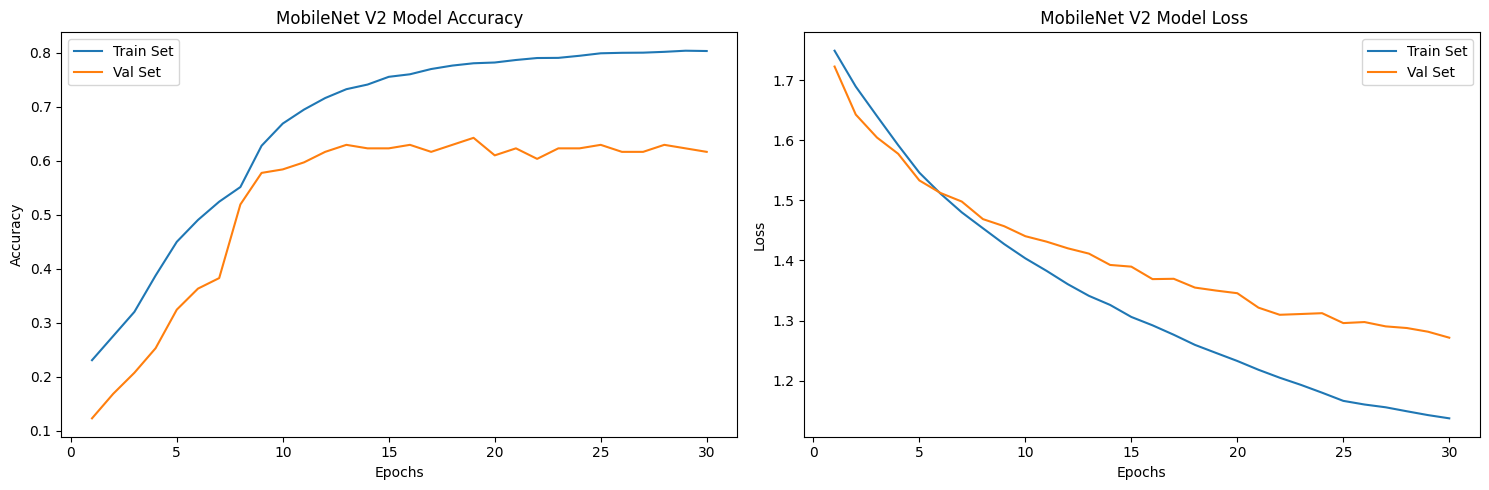

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [37]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl2_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 2s 77ms/step - loss: 1.3499 - accuracy: 0.6429
[1.3498938083648682, 0.6428571343421936]


In [38]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 0s 82ms/step - loss: 1.2632 - accuracy: 0.6984

 Test_Accuracy:- 0.6984127163887024


4/4 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       0.29      1.00      0.45         7
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        10
           4       1.00      0.67      0.80         6
           5       0.50      0.06      0.10        18

    accuracy                           0.70        63
   macro avg       0.78      0.79      0.71        63
weighted avg       0.76      0.70      0.66        63



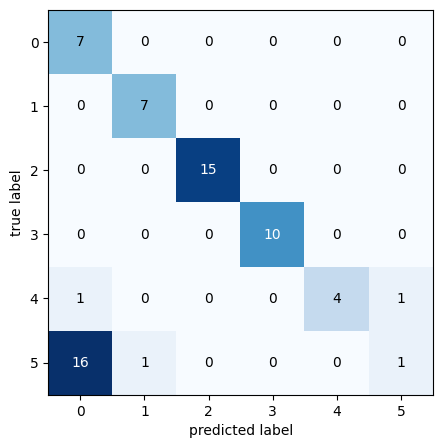

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("MobileNet-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

MobileNet-based Model Accuracy: 69.84%
Precision: 0.778
Recall: 0.787
F1 Score: 0.714


### Model 3 : DenseNet121


In [41]:
checkpoint = ModelCheckpoint('.mdl3_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [42]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet data
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes_ham, activation='softmax')(x)
model_ham = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
188/188 [==============================] - 216s 1s/step - loss: 1.0325 - accuracy: 0.6612 - val_loss: 0.8527 - val_accuracy: 0.6895
Epoch 2/10
188/188 [==============================] - 207s 1s/step - loss: 0.8241 - accuracy: 0.7023 - val_loss: 0.8056 - val_accuracy: 0.7049
Epoch 3/10
188/188 [==============================] - 208s 1s/step - loss: 0.7735 - accuracy: 0.7198 - val_loss: 0.7828 - val_accuracy: 0.7189
Epoch 4/10
188/188 [==============================] - 208s 1s/step - loss: 0.7360 - accuracy: 0.7289 - val_loss: 0.7452 - val_accuracy: 0.7309
Epoch 5/10
188/188 [==============================] - 207s 1s/step - loss: 0.7087 - accuracy: 0.7459 - val_loss: 0.7656 - val_accuracy: 0.7254
Epoch 6/10
188/188 [==============================] - 208s 1s/step - loss: 0.7051 - accuracy: 0.7367 - val_loss: 0.7344 - val_accuracy: 0.7304
Epoch 7/10
188/188 [==============================] - 208s 1s/step - loss: 0.

In [43]:
# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

In [44]:
# Unfreeze some layers in the base model

for layer in conv_base.layers[:150]:  # Freeze first 150 layers
    layer.trainable = False
for layer in conv_base.layers[150:]:  # Unfreeze the rest
    layer.trainable = True
# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])


history = model_mpox.fit(
    augmented_train_data,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=20,verbose=1, callbacks=callbacks
)

Epoch 1/20
1113/1113 [==============================] - ETA: 0s - loss: 1.5220 - accuracy: 0.5582
Epoch 1: val_accuracy improved from -inf to 0.46753, saving model to .mdl3_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1113/1113 [==============================] - 664s 577ms/step - loss: 1.5220 - accuracy: 0.5582 - val_loss: 1.5526 - val_accuracy: 0.4675 - lr: 1.0000e-04
Epoch 2/20
1113/1113 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.6281
Epoch 2: val_accuracy did not improve from 0.46753
1113/1113 [==============================] - 644s 579ms/step - loss: 1.3685 - accuracy: 0.6281 - val_loss: 1.4336 - val_accuracy: 0.4610 - lr: 1.0000e-04
Epoch 3/20
1113/1113 [==============================] - ETA: 0s - loss: 1.2555 - accuracy: 0.6830
Epoch 3: val_accuracy improved from 0.46753 to 0.69481, saving model to .mdl3_wts.hdf5
1113/1113 [==============================] - 643s 577ms/step - loss: 1.2555 - accuracy: 0.6830 - val_loss: 1.3607 - val_accuracy: 0.6948 - lr: 1.0000e-04
Epoch 4/20
1113/1113 [==============================] - ETA: 0s - loss: 1.1498 - accuracy: 0.7811
Epoch 4: val_accuracy did not improve from 0.69481
1113/1113 [==============================] - 642s 576ms

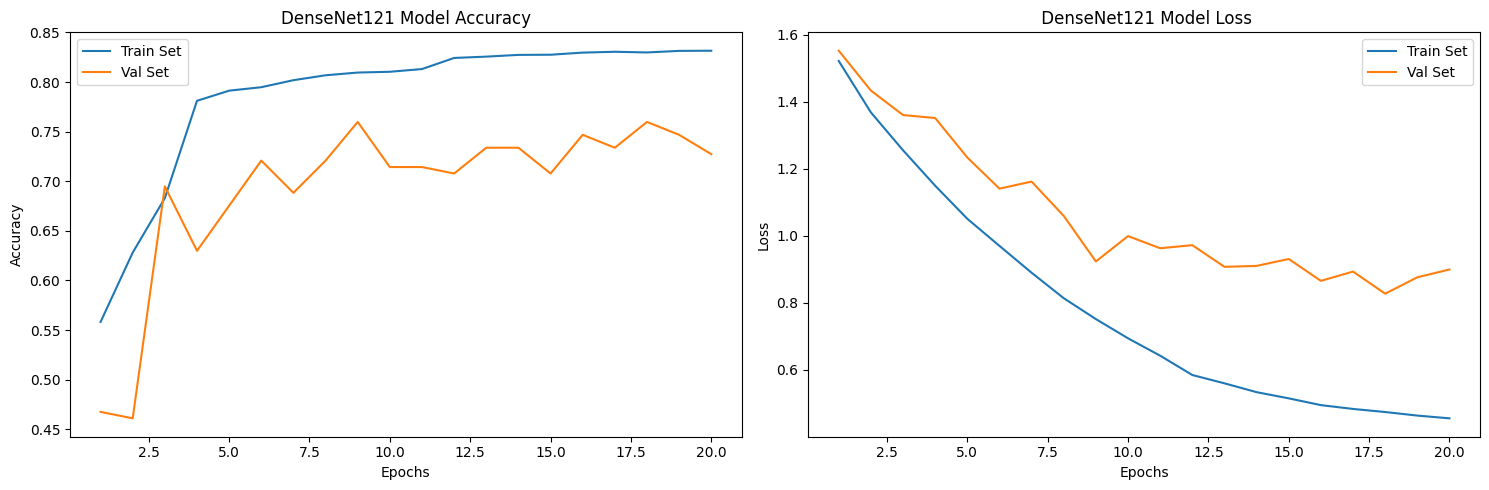

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' DenseNet121 Model Loss')

plt.tight_layout()
plt.show()

In [46]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl3_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 5s 286ms/step - loss: 0.9238 - accuracy: 0.7597
[0.923816442489624, 0.7597402334213257]


In [47]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 352ms/step - loss: 0.9349 - accuracy: 0.7778

 Test_Accuracy:- 0.7777777910232544


4/4 [==============================] - 3s 342ms/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.60      0.86      0.71         7
           2       0.86      0.80      0.83        15
           3       0.91      1.00      0.95        10
           4       0.00      0.00      0.00         6
           5       0.70      0.89      0.78        18

    accuracy                           0.78        63
   macro avg       0.68      0.71      0.68        63
weighted avg       0.72      0.78      0.74        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


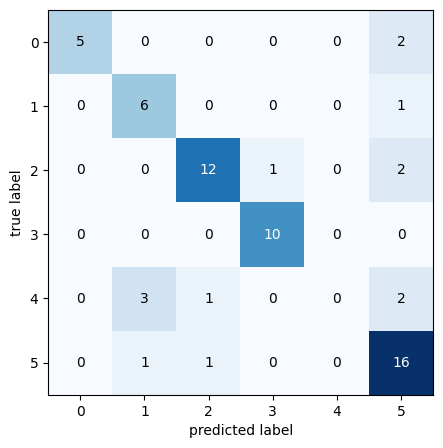

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("DenseNet121-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DenseNet121-based Model Accuracy: 77.78%
Precision: 0.677
Recall: 0.710
F1 Score: 0.683


LRP heatmap - ResNet50 model

Instructions for updating:
Colocations handled automatically by placer.


102967424/102967424 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1505: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ret = tf_session.TF_SessionRunCallable(self._session._session,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


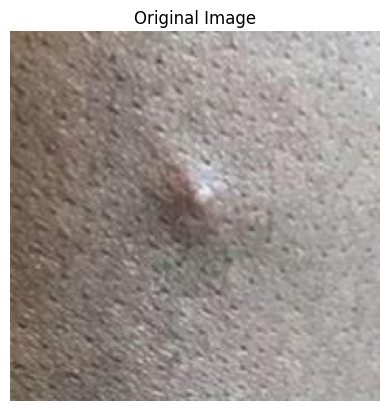

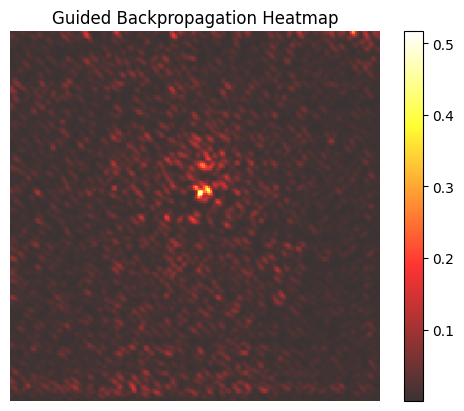

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = ResNet50(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_12_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.8, interpolation='nearest')
plt.axis('off')
plt.title('Guided Backpropagation Heatmap')
plt.colorbar()
plt.show()


LRP heatmap - MobileNetV2 model

14536120/14536120 [==============================] - 0s 0us/step


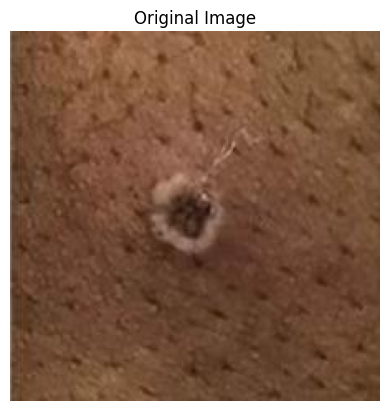

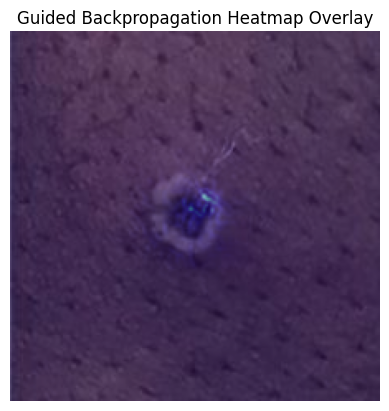

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = MobileNetV2(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_14_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)  # Use Guided Backpropagation

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Overlay the relevance heatmap on the original image
img_original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * analysis), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

plt.imshow(overlay)
plt.axis('off')
plt.title('Guided Backpropagation Heatmap Overlay')
plt.show()


33188688/33188688 [==============================] - 1s 0us/step


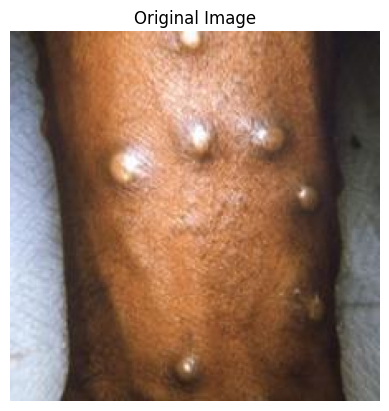

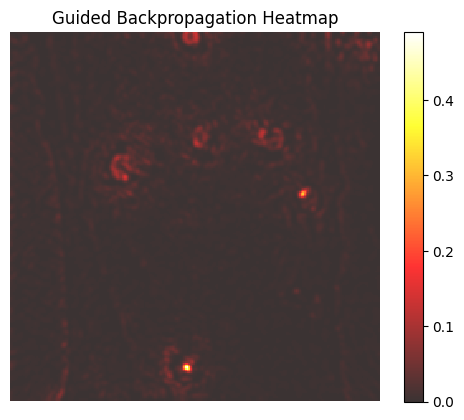

In [52]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = DenseNet121(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_114_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()


# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.8, interpolation='nearest')
plt.axis('off')
plt.title('Guided Backpropagation Heatmap')
plt.colorbar()
plt.show()
